# Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import os
import time
from setup_dataset import *

# Load matches

In [2]:
def get_actions_list(zigzag=False):

    if zigzag:

        ACTIONS = {
            "right": 2,
            "left": 3,
        }

    else:

        ACTIONS = {
            "noop": 0,
            "accelerate": 1,
            "right": 2,
            "left": 3,
            "break": 4,
            "right_break": 5,
            "left_break": 6,
            "right_accelerate": 7,
            "left_accelerate": 8,
        }

    return list(ACTIONS.values())

In [3]:
def set_device():

    use_gpu = input(("Do you want to use GPU (y/n)"))

    if use_gpu == 'y' and torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("Selected CPU")

    return device

In [6]:
data_info = {
    'datapath' : r"../1-generate/data/",
    'available_targets' : get_actions_list(zigzag=False),
    'match_list' : [2, 3],
    'start_frame' : 1,
    'end_frame' : 200,
    'device' : set_device(),
}

Do you want to use GPU (y/n)y
GPU is available


In [7]:
class dataset():

    def __init__(self, data_info):
        self.datapath = data_info['datapath']
        self.available_targets = data_info['available_targets']
        self.match_list = data_info['match_list']
        self.start_frame = data_info['start_frame']
        self.end_frame = data_info['end_frame']
        self.device = data_info['device']
        self.data, self.targets = self.setDataFromMatch()
        self.target_size = self.targets.shape
        self.seq_len = self.setSeqLen(self.data)
    
    def setSeqLen(self, X_train):
        return torch.FloatTensor(list(map(len,X_train)))

    def setDataFromMatch(self):
        frames_arr = []
        actions_arr = []

        for m in self.match_list:
            
            _, frames, actions, _, _ = self.load_npz(self.datapath, m)
            frames = frames[self.start_frame - 1:self.end_frame, 30:130, :]
            actions = actions[self.start_frame - 1:self.end_frame]
            
            action_one_hot = [self.prepare_action_data(i, self.available_targets) for i in actions]
            actions = np.array(action_one_hot)
            actions = actions.reshape(len(actions), -1)
            
            frames_arr.append(frames)
            actions_arr.append(actions)

        frames_arr = np.array(frames_arr)
        actions_arr = np.array(actions_arr)

        return frames_arr, actions_arr
    
    def normalize_images(self, frames):
        return frames/255

    def load_npz(self, data_path, m):
        
        path = data_path + "match_" + str(m) + "/npz/"

        actions = np.load(path + 'actions.npz')
        #lifes = np.load(path + 'lifes.npz')
        frames = np.load(path + 'frames.npz')
        rewards = np.load(path + 'rewards.npz')

        arr_actions = np.float32(actions.f.arr_0)
        # arr_lifes = lifes.f.arr_0
        arr_lifes = np.float32(np.array([]))
        arr_frames = np.float32(frames.f.arr_0)
        arr_rewards = np.float32(rewards.f.arr_0)

        print("Successfully loaded NPZ.")

        return arr_actions.shape[0], arr_frames, arr_actions, arr_rewards, arr_lifes

    def prepare_action_data(self, action, ACTIONS_LIST):

        new_action = np.zeros((1, len(ACTIONS_LIST)), dtype=int) 

        new_action[0, ACTIONS_LIST.index(action)] = 1

        return new_action

In [8]:
data = dataset(data_info)

Successfully loaded NPZ.
Successfully loaded NPZ.


In [9]:
data.seq_len

tensor([200., 200.])

In [10]:
data.data = torch.tensor(data.data)
data.targets = torch.tensor(data.targets)

In [11]:
data.data = data.data.view(data.data.shape[0], data.data.shape[1], -1)

In [12]:
data.data = data.data/255

In [13]:
"""
data = chunk_dataset(match_list=[1,2,3,4,5,6,7,8],
                     start_frame = 1,
                     end_frame = 1020
                    )
"""

'\ndata = chunk_dataset(match_list=[1,2,3,4,5,6,7,8],\n                     start_frame = 1,\n                     end_frame = 1020\n                    )\n'

In [14]:
def padSequence(raw):
    return pad_sequence(raw, batch_first=True).float()

In [15]:
def packPaddedSequence(seq, seq_len):
    return pack_padded_sequence(seq, seq_len, batch_first=True, enforce_sorted=False)

Prepare frames

In [14]:
"""data.data = padSequence(data.data)"""

'data.data = padSequence(data.data)'

In [15]:
"""padded_shape = data.data.shape"""

'padded_shape = data.data.shape'

In [16]:
"""data.data = packPaddedSequence(data.data, data.seq_len)"""

'data.data = packPaddedSequence(data.data, data.seq_len)'

Prepare targets

In [17]:
"""data.targets = padSequence(data.targets)"""

'data.targets = padSequence(data.targets)'

# Create model

In [16]:
def set_type_name():
    print("Choose type of RNN model:")
    print("1 - Simple RNN")
    print("2 - LSTM")
    print("3 - CNN")
    choise = int(input("type: "))
    if choise == 1:
        return "RNN"
    elif choise == 2:
        return "LSTM"
    elif choise == 3:
        return "CNN"
    else:
        return "Error"

In [17]:
model_info = {
    'input_size' : 12000,
    'hidden_neurons' : int(input("Number of hidden neurons: ")),
    'output_size' : 9,
    'n_epochs' : int(input("Number of epochs: ")),
    'min_loss' : 1e-5,
    'n_layers' : 1,
    'type' : set_type_name(),
}

Number of hidden neurons: 200
Number of epochs: 500
Choose type of RNN model:
1 - Simple RNN
2 - LSTM
3 - CNN
type: 2


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, data_info, model_info):
        super(LSTMModel, self).__init__()
        
        self.device = data_info['device']

        # Defining some parameters
        self.input_size = model_info['input_size']
        self.hidden_dim = model_info['hidden_neurons']
        self.n_layers = model_info['n_layers']
        self.output_size = model_info['output_size']

        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, self.n_layers, batch_first=True)  
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
        
        self.out = nn.Softmax()
    
    def forward(self, x):

        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)

        out, _ = self.lstm(x, hidden)

        """
        pad_embed_pack_lstm = self.lstm(x, hidden)
        pad_embed_pack_lstm_pad = pad_packed_sequence(pad_embed_pack_lstm[0], batch_first=True)
        
        outs, _ = pad_embed_pack_lstm_pad
        """

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        out = self.out(out)
        
        return out

    def init_hidden(self, batch_size):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(1, batch_size, self.hidden_dim).float()
        hidden_b = torch.randn(1, batch_size, self.hidden_dim).float()

        if self.device.type == 'cuda':
            hidden_a = hidden_a.cuda()
            hidden_b = hidden_b.cuda()

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)

In [19]:
def set_model(model_info):

    if model_info['type'] == "RNN":
        model = RNNModel(device=model_structure.device, 
                         input_size=model_structure.data_size, 
                         output_size=model_structure.output_size, 
                         hidden_dim=model_structure.hidden_neurons, 
                         n_layers=1)
    elif model_info['type'] == "LSTM":
        model = LSTMModel(data_info, model_info)
    elif model_info['type'] == "CNN":
        model = CNNLSTMModel(device=model_structure.device, 
                             input_size=model_structure.data_size, 
                             output_size=model_structure.output_size, 
                             hidden_dim=model_structure.hidden_neurons, 
                             n_layers=1)
    else:
        print("ERROR defining Model")

    return model

In [20]:
criterion = nn.MSELoss()
model = set_model(model_info)
optimizer = torch.optim.Adam(model.parameters())

# Prepare to store

In [21]:
def setName(data_info, model_info):
    x = [str(num) for num in data_info['match_list']]
    x = '-'.join(x)
    obs = input("write a observations without space and punctuations:")
    name = f"{model_info['type']}_{obs}_m{x}_f{data_info['start_frame']}to{data_info['end_frame']}_epoch{model_info['n_epochs']}_h{model_info['hidden_neurons']}"
    return name

In [22]:
def setPath(data_info, model_info):
    name = setName(data_info, model_info)
    newpath = f"models/" + name
    if not os.path.exists(newpath):
        print(f"models/" + name + " created")
        os.makedirs(newpath)
    else:
        print(f"models/" + name)
        print("ATTENTION! folder not created. Training informations will overwrite the existing one")
    return newpath

In [23]:
model_path = setPath(data_info, model_info)

write a observations without space and punctuations:teste
models/LSTM_teste_m2-3_f1to200_epoch500_h200 created


# Train model

In [24]:
def get_acc(predicted, target):
    
    predicted = torch.argmax(predicted, axis=1)
    target = torch.argmax(target, axis=1)

    correct = torch.sum(predicted == target)

    acc = correct/predicted.shape[0]
    return float(acc)

In [25]:
if data_info['device'].type == 'cuda':
    mymodel = model.cuda()
    X_train = data.data.cuda() 
    Y_train = data.targets.cuda()
else:
    mymodel = model
    X_train = data.data 
    Y_train = data.targets

In [26]:
train_loss_arr = np.array([])
train_acc_arr = np.array([])
valid_acc_arr = np.array([])

In [30]:
def create_info_string(current_epoch, last_epoch, train_loss, train_acc, valid_acc):
    epoch_info = f"Epoch: {current_epoch}/{last_epoch}-------------------------------------------\n"
    train_info = f"Train -> Loss: {train_loss:.15f} Acc: {train_acc:.15f}\n"
    valid_info = f"Valid -> Acc: {valid_acc:.15f}\n"
    return epoch_info, train_info, valid_info

In [31]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=len(data.data), shuffle=False)

In [33]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(data.data)):
        
    start_time_processing = time.time()

    best_loss = 1
    first_epoch = True
    
    loss_file = open(model_path + '/' + f"loss_file_{fold}.txt", "w")
    
    print(f'Fold: {fold}')

    X_train = data.data[train_ids]
    Y_train = data.targets[train_ids]
    X_valid = data.data[test_ids]
    Y_valid = data.targets[test_ids]

    #X_train = padSequence(tuple(X_train))
    #X_valid = padSequence(tuple(X_valid))
    """
    X_train_padded_shape = X_train.shape
    X_train_seq_len = data.seq_len[train_ids]
    X_train = packPaddedSequence(X_train, X_train_seq_len)
    """

    """
    X_valid_padded_shape = X_valid.shape
    X_valid_seq_len = data.seq_len[test_ids]
    X_valid = packPaddedSequence(X_valid, X_valid_seq_len)
    """
    """
    if data_info['device'].type == 'cuda':
        mymodel = model.cuda()
        X_train = X_train.cuda() 
        Y_train = Y_train.cuda()
        X_valid = X_valid.cuda() 
        Y_valid = Y_valid.cuda()
    """
    if data_info['device'].type == 'cuda':
        mymodel = model.cuda()
        X_valid = X_valid.cuda() 
        Y_valid = Y_valid.cuda()
    
    for epoch in range(1, model_info['n_epochs'] + 1):
        
        predicted_outputs = torch.tensor([])

        for sequence, targets in zip(X_train, Y_train):
            
            if data_info['device'].type == 'cuda':
                sequence = sequence.cuda()
                targets = targets.cuda()
            
            mymodel.train()

            optimizer.zero_grad()
            output = mymodel(sequence.view(1, sequence.shape[0], sequence.shape[1]))
            predicted_outputs = torch.cat((predicted_outputs.to('cpu'), output.to('cpu')), 0)

            loss = criterion(output, targets.view(-1, model_info['output_size']).float())
            loss.backward()
            optimizer.step()

        if epoch%10 == 0:

            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(predicted_outputs.reshape(-1, len(data.available_targets)), Y_train.reshape(-1, len(data.available_targets))))
            
            mymodel.eval()
            
            output = mymodel(X_valid)
            valid_acc_arr  = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(data.available_targets))))
                        
            epoch_info, train_info, valid_info = create_info_string(epoch, 
                                                                    model_info['n_epochs'], 
                                                                    train_loss_arr[-1], 
                                                                    train_acc_arr[-1],
                                                                    valid_acc_arr[-1])
            loss_file.write(epoch_info)
            loss_file.write(train_info)
            loss_file.write(valid_info)
            print(epoch_info, end = '')
            print(train_info, end = '')
            print(valid_info, end = '')

            if train_loss_arr[-1] < best_loss:
                state = {'epoch': epoch, 
                         'state_dict': mymodel.state_dict(),
                         'optimizer': optimizer.state_dict(), 
                         'losslogger': loss.item(), 
                        }
                torch.save(state, model_path + '/' + f'model_fold_{fold}')
                best_loss = loss.item()
            else:
                print("model not saved")
                
    time_info = "--- %s seconds ---" % (time.time() - start_time_processing)
    loss_file.write(time_info)
    print(time_info)

    loss_file.close()
    np.savez(model_path + '/' + f"train_loss_arr_{fold}", train_loss_arr)

Fold: 0


C:\Users\alece\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 10/500-------------------------------------------
Train -> Loss: 0.026529757305980 Acc: 0.855000019073486
Valid -> Acc: 0.810000002384186
Epoch: 20/500-------------------------------------------
Train -> Loss: 0.017210021615028 Acc: 0.930000007152557
Valid -> Acc: 0.904999971389771
Epoch: 30/500-------------------------------------------
Train -> Loss: 0.011362924240530 Acc: 0.954999983310699
Valid -> Acc: 0.774999976158142
Epoch: 40/500-------------------------------------------
Train -> Loss: 0.008974323049188 Acc: 0.964999973773956
Valid -> Acc: 0.824999988079071
Epoch: 50/500-------------------------------------------
Train -> Loss: 0.007899773307145 Acc: 0.964999973773956
Valid -> Acc: 0.824999988079071
Epoch: 60/500-------------------------------------------
Train -> Loss: 0.007780951447785 Acc: 0.964999973773956
Valid -> Acc: 0.859999954700470
Epoch: 70/500-------------------------------------------
Train -> Loss: 0.007162958383560 Acc: 0.964999973773956
Valid -> Acc: 0.8

Epoch: 70/500-------------------------------------------
Train -> Loss: 0.005585136357695 Acc: 0.985000014305115
Valid -> Acc: 0.834999978542328
Epoch: 80/500-------------------------------------------
Train -> Loss: 0.005383864510804 Acc: 0.980000019073486
Valid -> Acc: 0.829999983310699
Epoch: 90/500-------------------------------------------
Train -> Loss: 0.005253995768726 Acc: 0.980000019073486
Valid -> Acc: 0.870000004768372
Epoch: 100/500-------------------------------------------
Train -> Loss: 0.005108710378408 Acc: 0.980000019073486
Valid -> Acc: 0.799999952316284
Epoch: 110/500-------------------------------------------
Train -> Loss: 0.005569972563535 Acc: 0.980000019073486
Valid -> Acc: 0.799999952316284
model not saved
Epoch: 120/500-------------------------------------------
Train -> Loss: 0.005005047656596 Acc: 0.985000014305115
Valid -> Acc: 0.779999971389771
Epoch: 130/500-------------------------------------------
Train -> Loss: 0.005371481645852 Acc: 0.9800000190734

[0.06779106 0.06019022 0.05163167 0.04355165 0.03756144 0.03416507
 0.03138779 0.02904316 0.02673046 0.02524197 0.02300601 0.02141168
 0.01987032 0.01858283 0.01737118 0.01624748 0.01497382 0.01395418
 0.01313718 0.01204579 0.01116655 0.01040545 0.00957519 0.00893641
 0.00839831 0.00805861 0.0073733  0.00694257 0.00651737 0.00616217
 0.00594118 0.00515433 0.00440766 0.00386135 0.00304779 0.00244569
 0.00191445 0.00152155 0.00131    0.00125397 0.00091779 0.00080722
 0.00085187 0.00075091 0.00063316 0.00055143 0.00056753 0.00046632
 0.0004399  0.00054244 0.05188608 0.04749809 0.04384062 0.04055969
 0.03683074 0.0342757  0.03172548 0.03005379 0.02826169 0.02666542
 0.02567464 0.02506769 0.02333365 0.02172856 0.02031099 0.01941531
 0.01883428 0.01798033 0.01919792 0.01736029 0.01684406 0.01558691
 0.01488767 0.0138324  0.01366408 0.01265527 0.01201956 0.01141775
 0.01089693 0.01180601 0.01096421 0.00981329 0.00989723 0.00968197
 0.00872147 0.00813628 0.00791865 0.00782203 0.00739184 0.0076

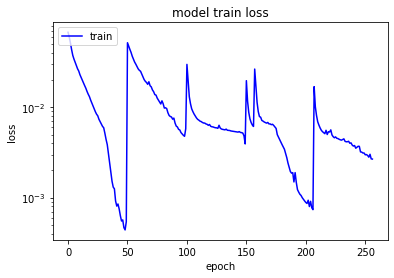

In [41]:
import matplotlib.pyplot as plt

for fold in range(len(data.data)):
    # summarize history for loss
    
    train_loss_arr = np.load(model_path + '/' + f"train_loss_arr_{fold}.npz")
    train_loss_arr = train_loss_arr.f.arr_0
    
    plt.clf()
    plt.plot(train_loss_arr, color='blue')
    plt.title('model train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.yscale('log')
    plt.savefig(model_path + '/' + f'train_loss_{fold}.png')

In [35]:
data.data.shape

torch.Size([2, 200, 12000])

In [ ]:
"""start_time_processing = time.time()

loss_file = open(model_path + '/' + "loss_file.txt", "w")

best_loss = 1
first_epoch = True

for fold, (train_ids, test_ids) in enumerate(kfold.split(data.data)):
    
    print(f'Fold: {fold}')

    X_train = data.data[train_ids]
    Y_train = data.targets[train_ids]
    X_valid = data.data[test_ids]
    Y_valid = data.targets[test_ids]
    
    X_train = padSequence(X_train)
    X_valid = padSequence(X_valid)
    
    X_train_padded_shape = X_train.shape
    X_train_seq_len = data.seq_len[train_ids]
    X_train = packPaddedSequence(X_train, X_train_seq_len)
    
    X_valid_padded_shape = X_valid.shape
    X_valid_seq_len = data.seq_len[test_ids]
    X_valid = packPaddedSequence(X_valid, X_valid_seq_len)
    
    if data_info['device'].type == 'cuda':
        mymodel = model.cuda()
        X_train = X_train.cuda() 
        Y_train = Y_train.cuda()
        X_valid = X_valid.cuda() 
        Y_valid = Y_valid.cuda()
    
    for epoch in range(1, model_info['n_epochs'] + 1):

        mymodel.train()

        optimizer.zero_grad()
        output = mymodel(X_train)

        loss = criterion(output, Y_train.view(-1,model_info['output_size']).float())
        loss.backward()
        optimizer.step()

        if epoch%10 == 0:

            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(data.available_targets))))
            
            mymodel.eval()
            
            output = mymodel(X_valid)
            valid_acc_arr  = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(data.available_targets))))
                        
            epoch_info, train_info, valid_info = create_info_string(epoch, 
                                                                    model_info['n_epochs'], 
                                                                    train_loss_arr[-1], 
                                                                    train_acc_arr[-1],
                                                                    valid_acc_arr[-1])
            loss_file.write(epoch_info)
            loss_file.write(train_info)
            loss_file.write(valid_info)
            print(epoch_info)
            print(train_info)
            print(valid_info)

            if train_loss_arr[-1] < best_loss:
                state = {'epoch': epoch, 
                         'state_dict': mymodel.state_dict(),
                         'optimizer': optimizer.state_dict(), 
                         'losslogger': loss.item(), 
                        }
                torch.save(state, model_path + '/' + f'model_fold_{fold}')
                best_loss = loss.item()
            else:
                print("model not saved")
                
time_info = "--- %s seconds ---" % (time.time() - start_time_processing)
loss_file.write(time_info)
print(time_info)

loss_file.close()
np.savez(model_path + '/' + "train_loss_arr", train_loss_arr)"""

In [ ]:
"""start_time_processing = time.time()

loss_file = open(model_path + '/' + "loss_file.txt", "w")

best_loss = 1
first_epoch = True

for fold, (train_ids, test_ids) in enumerate(kfold.split(data.data)):
    
    print(f'Fold: {fold}')

    X_train = data.data[train_ids]
    Y_train = data.targets[train_ids]
    X_valid = data.data[test_ids]
    Y_valid = data.targets[test_ids]
    
    X_train = padSequence(X_train)
    X_valid = padSequence(X_valid)
    
    X_valid_padded_shape = X_valid.shape
    X_valid_seq_len = data.seq_len[test_ids]
    X_valid = packPaddedSequence(X_valid, X_valid_seq_len)
    
    if data_info['device'].type == 'cuda':
        mymodel = model.cuda()
        X_train = X_train.cuda() 
        Y_train = Y_train.cuda()
        X_valid = X_valid.cuda() 
        Y_valid = Y_valid.cuda()
    
    for epoch in range(1, model_info['n_epochs'] + 1):
        
        print("epoch:", epoch)
        
        mymodel.train()
            
        for sequence, targets, seq_len2 in zip(X_train, Y_train, data.seq_len[train_ids]):
            
            print(sequence.shape)
            print(targets.shape)
            
            sequence = sequence.view(1, sequence.shape[0], sequence.shape[1])
            X_train_padded_shape = sequence.shape
            X_train_seq_len = torch.tensor([seq_len2])
            sequence = packPaddedSequence(sequence, X_train_seq_len)

            optimizer.zero_grad()
            output = mymodel(sequence)

            loss = criterion(output, targets.view(-1,model_info['output_size']).float())
            loss.backward()
            optimizer.step()

        if epoch%10 == 0:

            train_loss_arr = np.append(train_loss_arr, loss.item())
            train_acc_arr  = np.append(train_acc_arr, get_acc(output, sequence.reshape(-1, len(data.available_targets))))
            
            mymodel.eval()
            
            output = mymodel(X_valid)
            valid_acc_arr  = np.append(valid_acc_arr, get_acc(output, Y_valid.reshape(-1, len(data.available_targets))))
                        
            epoch_info, train_info, valid_info = create_info_string(epoch, 
                                                                    model_info['n_epochs'], 
                                                                    train_loss_arr[-1], 
                                                                    train_acc_arr[-1],
                                                                    valid_acc_arr[-1])
            loss_file.write(epoch_info)
            loss_file.write(train_info)
            loss_file.write(valid_info)
            print(epoch_info)
            print(train_info)
            print(valid_info)

            if train_loss_arr[-1] < best_loss:
                state = {'epoch': epoch, 
                         'state_dict': mymodel.state_dict(),
                         'optimizer': optimizer.state_dict(), 
                         'losslogger': loss.item(), 
                        }
                torch.save(state, model_path + '/' + f'model_fold_{fold}')
                best_loss = loss.item()
            else:
                print("model not saved")
                
time_info = "--- %s seconds ---" % (time.time() - start_time_processing)
loss_file.write(time_info)
print(time_info)

loss_file.close()
np.savez(model_path + '/' + "train_loss_arr", train_loss_arr)"""